# Time processing for every ONNX nodes in a graph

The following notebook show how long the runtime spends in each node of an ONNX graph.

In [1]:
from jyquickhelper import add_notebook_menu
add_notebook_menu()

In [2]:
%load_ext mlprodict

## LogisticRegression

In [3]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
iris = load_iris()
X, y = iris.data, iris.target
X_train, X_test, y_train, y_test = train_test_split(X, y)
clr = LogisticRegression(solver='liblinear')
clr.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [4]:
import numpy
from mlprodict.onnx_conv import to_onnx
onx = to_onnx(clr, X_test.astype(numpy.float32))
with open("logreg_time.onnx", "wb") as f:
    f.write(onx.SerializeToString())
# add -l 1 if nothing shows up
%onnxview onx

In [5]:
from mlprodict.onnxrt import OnnxInference
import pandas
oinf = OnnxInference(onx)
res = oinf.run({'X': X_test}, node_time=True)
pandas.DataFrame(list(res[1]))

,i,name,op_type,time
0,0,LinearClassifier,LinearClassifier,0.019910
1,1,Normalizer,Normalizer,0.000058
2,2,Cast,Cast,0.000010
3,3,ZipMap,ZipMap,0.000009


In [6]:
oinf.run({'X': X_test})['output_probability'][:5]

{0: array([1.66310797e-03, 4.36526109e-04, 9.64064486e-04, 3.61135710e-02,
        8.50042694e-01]),
 1: array([0.32577738, 0.24091185, 0.35773048, 0.73769649, 0.14994612]),
 2: array([6.72559515e-01, 7.58651623e-01, 6.41305458e-01, 2.26189935e-01,
        1.11827722e-05])}

## Measure time spent in each node


With parameter ``node_time=True``, method *run* returns the output and time measurement.

In [7]:
exe = oinf.run({'X': X_test}, node_time=True)
exe[1]

[{'i': 0,
  'name': 'LinearClassifier',
  'op_type': 'LinearClassifier',
  'time': 0.00024170000000012237},
 {'i': 1,
  'name': 'Normalizer',
  'op_type': 'Normalizer',
  'time': 4.120000000007451e-05},
 {'i': 2, 'name': 'Cast', 'op_type': 'Cast', 'time': 1.440000000130226e-05},
 {'i': 3,
  'name': 'ZipMap',
  'op_type': 'ZipMap',
  'time': 1.0700000000696264e-05}]

In [8]:
import pandas
pandas.DataFrame(exe[1])

,i,name,op_type,time
0,0,LinearClassifier,LinearClassifier,0.000242
1,1,Normalizer,Normalizer,0.000041
2,2,Cast,Cast,0.000014
3,3,ZipMap,ZipMap,0.000011


## Logistic regression: python runtime vs onnxruntime

Function [enumerate_validated_operator_opsets](http://www.xavierdupre.fr/app/mlprodict/helpsphinx/mlprodict/onnxrt/validate/validate.html?highlight=enumerate_validated_operator_opsets#mlprodict.onnxrt.validate.validate.enumerate_validated_operator_opsets) implements automated tests for every model with artificial data. Option ``node_time`` automatically returns the time spent in each node and does it multiple time.

In [9]:
from mlprodict.onnxrt.validate import enumerate_validated_operator_opsets
res = list(enumerate_validated_operator_opsets(
            verbose=0, models={"LogisticRegression"}, opset_min=11,
            runtime='python', debug=False, node_time=True,
            filter_exp=lambda m, p: p == "b-cl"))

In [10]:
import pandas
df = pandas.DataFrame(res[0]['bench-batch'])
df['step'] = df.apply(lambda row: '{}-{}'.format(row['i'], row["name"]), axis=1)
df

,i,name,op_type,time,N,max_time,min_time,repeat,number,step
0,0,LinearClassifier,LinearClassifier,0.000015,1,0.000019,0.000013,20,30,0-LinearClassifier
1,1,Normalizer,Normalizer,0.000014,1,0.000019,0.000012,20,30,1-Normalizer
2,2,Cast,Cast,0.000004,1,0.000005,0.000003,20,30,2-Cast
3,3,ZipMap,ZipMap,0.000004,1,0.000004,0.000003,20,30,3-ZipMap
4,0,LinearClassifier,LinearClassifier,0.000016,10,0.000020,0.000015,20,20,0-LinearClassifier
5,1,Normalizer,Normalizer,0.000013,10,0.000015,0.000013,20,20,1-Normalizer
6,2,Cast,Cast,0.000004,10,0.000004,0.000003,20,20,2-Cast
7,3,ZipMap,ZipMap,0.000003,10,0.000004,0.000003,20,20,3-ZipMap
8,0,LinearClassifier,LinearClassifier,0.000018,100,0.000020,0.000018,5,8,0-LinearClassifier
9,1,Normalizer,Normalizer,0.000016,100,0.000017,0.000015,5,8,1-Normalizer


Following tables shows the time spent in each node, it is relative to the total time. For one observation, the runtime spends 10% of the time in ZipMap, it is only 1% or 2% with 10 observations. These proportions change due to the computing cost of each node.

In [11]:
piv = df.pivot('step', 'N', 'time')
total = piv.sum(axis=0)
piv / total

N,1,10,100,1000,10000,100000
step,,,,,,
0-LinearClassifier,0.415387,0.451179,0.448553,0.499290,0.505476,0.501581
1-Normalizer,0.375868,0.366065,0.391894,0.415909,0.470184,0.481992
2-Cast,0.110045,0.099186,0.087503,0.045603,0.018619,0.015090
3-ZipMap,0.098701,0.083571,0.072051,0.039198,0.005722,0.001337


The python implementation of *ZipMap* does not change the data but wraps in into a frozen class [ArrayZipMapDitionary](https://github.com/sdpython/mlprodict/blob/master/mlprodict/onnxrt/ops_cpu/op_zipmap.py#L90) which mocks a list of dictionaries *pandas* can ingest to create a DataFrame. The cost is a fixed cost and does not depend on the number of processed rows.

In [12]:
from pyquickhelper.pycode.profiling import profile
bigX = numpy.random.randn(100000, X_test.shape[1]).astype(numpy.float32)
df = profile(lambda: oinf.run({'X': bigX}), as_df=True)[1]
df['file'] = df['file'].apply(lambda s: s.split("GitHub")[-1])
df

,namefct,file,ncalls1,ncalls2,tin,cum_tin,tall,cum_tall
0,onnx_inference.py:315-run,\mlprodict\mlprodict\onnxrt\onnx_inference.py:315,3,3,4.590000e-05,5.890000e-05,2.134240e-02,3.202010e-02
1,394-_run_sequence_runtime,\mlprodict\mlprodict\onnxrt\onnx_inference.py:394,7,7,1.235000e-04,1.559000e-04,2.129600e-02,3.196020e-02
2,onnx_inference_node.py:112-run,\mlprodict\mlprodict\onnxrt\onnx_inference_nod...,24,24,1.292000e-04,2.185000e-04,2.117070e-02,3.180070e-02
3,_op.py:199-run,\mlprodict\mlprodict\onnxrt\ops_cpu\_op.py:199,4,4,2.855900e-03,2.863400e-03,2.046390e-02,3.069960e-02
4,<ipython-input-12-d4f3af6cfacf>:3-<lambda>,<ipython-input-12-d4f3af6cfacf>:3,2,2,1.750000e-05,1.750000e-05,2.135990e-02,2.135990e-02
5,_op.py:312-run,\mlprodict\mlprodict\onnxrt\ops_cpu\_op.py:312,2,2,1.570000e-05,2.870000e-05,1.202220e-02,1.803980e-02
6,op_linear_classifier.py:38-_run,\mlprodict\mlprodict\onnxrt\ops_cpu\op_linear_...,3,3,2.851000e-03,5.689800e-03,9.165000e-03,1.516690e-02
7,_op.py:279-run,\mlprodict\mlprodict\onnxrt\ops_cpu\_op.py:279,2,2,1.330000e-05,2.180000e-05,8.470700e-03,1.271030e-02
8,op_normalizer.py:61-_run,\mlprodict\mlprodict\onnxrt\ops_cpu\op_normali...,3,3,3.029700e-03,3.039300e-03,8.443000e-03,1.266930e-02
9,op_normalizer.py:39-norm_l1,\mlprodict\mlprodict\onnxrt\ops_cpu\op_normali...,3,3,3.026500e-03,6.044500e-03,5.411200e-03,9.625800e-03


In [13]:
%matplotlib inline

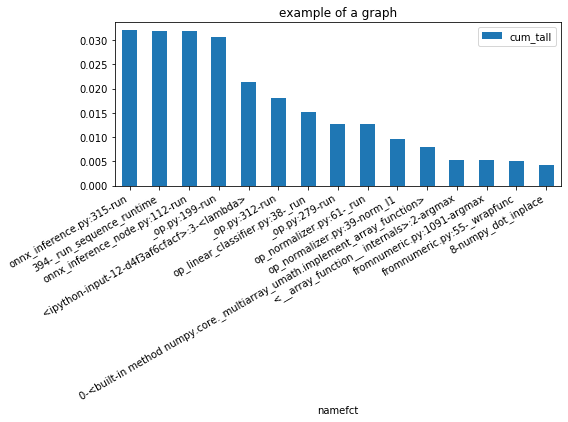

In [14]:
ax = df[['namefct', 'cum_tall']].head(n=15).set_index('namefct').plot(kind='bar', figsize=(8, 3), rot=30)
ax.set_title("example of a graph")
for la in ax.get_xticklabels():
    la.set_horizontalalignment('right');

The class *ArrayZipMapDictionary* is fast to build but has an overhead after that because it builds data when needed.

In [15]:
res = oinf.run({'X': bigX})
prob = res['output_probability']
type(prob)

mlprodict.onnxrt.ops_cpu.op_zipmap.ArrayZipMapDictionary

In [16]:
%timeit pandas.DataFrame(prob)

550 ms ± 16.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [17]:
list_of_dict = [v.asdict() for v in prob]
%timeit pandas.DataFrame(list_of_dict)

118 ms ± 2.55 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


But if you just need to do the following:

In [18]:
%timeit pandas.DataFrame(prob).values

644 ms ± 61.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Then, you can just do that:

In [19]:
print(prob.columns)
%timeit prob.values

[0, 1, 2]
152 ns ± 25.3 ns per loop (mean ± std. dev. of 7 runs, 10000000 loops each)


And then:


In [20]:
%timeit pandas.DataFrame(prob.values, columns=prob.columns)

164 µs ± 2.45 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


We can then compare to what *onnxruntime* would do when the runtime is called indenpently for each node. We use the runtime named [onnxruntime2](http://www.xavierdupre.fr/app/mlprodict/helpsphinx/onnx_runtime.html?highlight=onnxruntime2#onnxruntime2-independent-onnxruntime-for-every-node). Class *OnnxInference* splits the ONNX graph into multiple ONNX graphs, one for each node, and then calls *onnxruntime* for each of them indenpently. *Python* handles the graph logic.

In [21]:
res = list(enumerate_validated_operator_opsets(
            verbose=0, models={"LogisticRegression"}, opset_min=11,
            runtime='onnxruntime2', debug=False, node_time=True))

EP Error: [ONNXRuntimeError] : 2 : INVALID_ARGUMENT : Got invalid dimensions for input: probability_tensor for the following indices
 index: 0 Got: 38 Expected: 0
 Please fix either the inputs or the model. using ['CPUExecutionProvider']
Falling back to ['CPUExecutionProvider'] and retrying.
EP Error: [ONNXRuntimeError] : 2 : INVALID_ARGUMENT : Got invalid dimensions for input: probability_tensor for the following indices
 index: 0 Got: 38 Expected: 0
 Please fix either the inputs or the model. using ['CPUExecutionProvider']
Falling back to ['CPUExecutionProvider'] and retrying.
EP Error: [ONNXRuntimeError] : 2 : INVALID_ARGUMENT : Got invalid dimensions for input: probability_tensor for the following indices
 index: 0 Got: 38 Expected: 0
 Please fix either the inputs or the model. using ['CPUExecutionProvider']
Falling back to ['CPUExecutionProvider'] and retrying.
EP Error: [ONNXRuntimeError] : 2 : INVALID_ARGUMENT : Got invalid dimensions for input: probability_tensor for the follow

In [22]:
if '_6ort_run_batch_exc' in res[0]:
    m = "Something went wrong.", res[0]['_6ort_run_batch_exc']
else:
    df = pandas.DataFrame(res[0]['bench-batch'])
    df['step'] = df.apply(lambda row: '{}-{}'.format(row['i'], row["name"]), axis=1)
    piv = df.pivot('step', 'N', 'time')
    total = piv.sum(axis=0)
    m = piv / total
m

('Something went wrong.',
 RuntimeError("Predictions failed. List of inputs: ['probability_tensor'], class=<class 'skl2onnx.algebra.onnx_ops.OnnxNormalizer'>\ndtypes={'probability_tensor': dtype('float32')}\nshapes={'probability_tensor': (38, 2)}\nexpected=['probability_tensor']\nexpected=['tensor(float)']\nexception=[ONNXRuntimeError] : 2 : INVALID_ARGUMENT : Got invalid dimensions for input: probability_tensor for the following indices\n index: 0 Got: 38 Expected: 0\n Please fix either the inputs or the model."))

*onnxruntime* creates a new container each time a ZipMap is executed. That's whay it takes that much time and the ratio increases when the number of observations increases.

## GaussianProcessRegressor

This operator is slow for small batches compare to *scikit-learn* but closes the gap as the batch size increases. Let's see where the time goes.

In [23]:
res = list(enumerate_validated_operator_opsets(
            verbose=0, models={"GaussianProcessRegressor"}, opset_min=11,
            runtime='python', debug=False, node_time=True,
            filter_exp=lambda m, p: p == "b-reg"))

In [24]:
df = pandas.DataFrame(res[0]['bench-batch'])
df['step'] = df.apply(lambda row: '{0:02d}-{1}'.format(row['i'], row["name"]), axis=1)
df.head()

,i,name,op_type,time,N,max_time,min_time,repeat,number,step
0,0,Sc_Scan,Scan,0.003943,1,0.004320,0.003404,20,30,00-Sc_Scan
1,1,kgpd_Transpose,Transpose,0.000010,1,0.000013,0.000007,20,30,01-kgpd_Transpose
2,2,kgpd_Sqrt,Sqrt,0.000009,1,0.000011,0.000006,20,30,02-kgpd_Sqrt
3,3,kgpd_Div,Div,0.000010,1,0.000011,0.000007,20,30,03-kgpd_Div
4,4,kgpd_Mul,Mul,0.000006,1,0.000008,0.000005,20,30,04-kgpd_Mul


In [25]:
pivpy = df.pivot('step', 'N', 'time')
total = pivpy.sum(axis=0)
pivpy / total

N,1,10,100,1000,10000,100000
step,,,,,,
00-Sc_Scan,0.973346,0.961953,0.891337,0.621001,0.442023,0.619160
01-kgpd_Transpose,0.002466,0.002331,0.001667,0.001114,0.000328,0.000027
02-kgpd_Sqrt,0.002156,0.002238,0.002223,0.003750,0.005049,0.005197
03-kgpd_Div,0.002346,0.002653,0.002693,0.003976,0.004929,0.004790
04-kgpd_Mul,0.001591,0.001969,0.001877,0.002494,0.004185,0.004264
05-kgpd_Sin,0.001955,0.005715,0.030748,0.103689,0.141253,0.098962
06-kgpd_Div1,0.001507,0.001883,0.002166,0.003801,0.005236,0.004129
07-kgpd_Pow,0.002499,0.007369,0.043511,0.188671,0.297541,0.196722
08-kgpd_Mul1,0.001499,0.001938,0.001983,0.004019,0.006466,0.004651


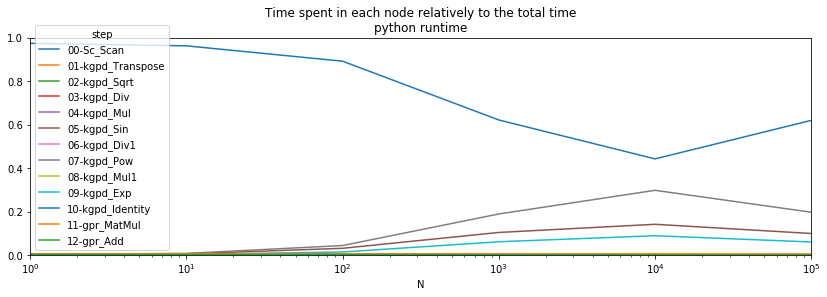

In [26]:
ax = (pivpy / total).T.plot(logx=True, figsize=(14, 4))
ax.set_ylim([0,1])
ax.set_title("Time spent in each node relatively to the total time\npython runtime");

The operator *Scan* is clearly time consuming when the batch size is small. *onnxruntime* is more efficient for this one.

In [27]:
res = list(enumerate_validated_operator_opsets(
            verbose=0, models={"GaussianProcessRegressor"}, opset_min=11,
            runtime='onnxruntime2', debug=False, node_time=True,
            filter_exp=lambda m, p: p == "b-reg"))

EP Error: [ONNXRuntimeError] : 2 : INVALID_ARGUMENT : Got invalid dimensions for input: scan1_1789246223472 for the following indices
 index: 0 Got: 112 Expected: 0
 index: 1 Got: 38 Expected: 0
 Please fix either the inputs or the model. using ['CPUExecutionProvider']
Falling back to ['CPUExecutionProvider'] and retrying.
EP Error: [ONNXRuntimeError] : 2 : INVALID_ARGUMENT : Got invalid dimensions for input: scan1_1789246223472 for the following indices
 index: 0 Got: 112 Expected: 0
 index: 1 Got: 38 Expected: 0
 Please fix either the inputs or the model. using ['CPUExecutionProvider']
Falling back to ['CPUExecutionProvider'] and retrying.
EP Error: [ONNXRuntimeError] : 2 : INVALID_ARGUMENT : Got invalid dimensions for input: scan1_1789249649520 for the following indices
 index: 0 Got: 112 Expected: 0
 index: 1 Got: 38 Expected: 0
 Please fix either the inputs or the model. using ['CPUExecutionProvider']
Falling back to ['CPUExecutionProvider'] and retrying.
EP Error: [ONNXRuntimeErr

In [28]:
try:
    df = pandas.DataFrame(res[0]['bench-batch'])
except KeyError as e:
    print("No model available.")
    r, df = None, None
if df is not None:
    df['step'] = df.apply(lambda row: '{0:02d}-{1}'.format(row['i'], row["name"]), axis=1)
    pivort = df.pivot('step', 'N', 'time')
    total = pivort.sum(axis=0)
    r = pivort / total
r

No model available.


In [29]:
if r is not None:
    ax = (pivort / total).T.plot(logx=True, figsize=(14, 4))
    ax.set_ylim([0,1])
    ax.set_title("Time spent in each node relatively to the total time\nonnxtunime");

The results are relative. Let's see which runtime is best node by node.

In [30]:
if r is not None:
    r = (pivort - pivpy) / pivpy
r

Based on this, *onnxruntime* is faster for operators *Scan*, *Pow*, *Exp* and slower for all the others.

## Measuring the time with a custom dataset

We use the example [Comparison of kernel ridge and Gaussian process regression](https://scikit-learn.org/stable/auto_examples/gaussian_process/plot_compare_gpr_krr.html#sphx-glr-auto-examples-gaussian-process-plot-compare-gpr-krr-py).

In [31]:
import numpy
import pandas
import matplotlib.pyplot as plt
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import GridSearchCV
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import WhiteKernel, ExpSineSquared

rng = numpy.random.RandomState(0)

# Generate sample data
X = 15 * rng.rand(100, 1)
y = numpy.sin(X).ravel()
y += 3 * (0.5 - rng.rand(X.shape[0]))  # add noise

gp_kernel = ExpSineSquared(1.0, 5.0, periodicity_bounds=(1e-2, 1e1))
gpr = GaussianProcessRegressor(kernel=gp_kernel)
gpr.fit(X, y)

GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
                         kernel=ExpSineSquared(length_scale=1, periodicity=5),
                         n_restarts_optimizer=0, normalize_y=False,
                         optimizer='fmin_l_bfgs_b', random_state=None)

In [32]:
onx = to_onnx(gpr, X_test.astype(numpy.float64), dtype=numpy.float64)
with open("gpr_time.onnx", "wb") as f:
    f.write(onx.SerializeToString())
%onnxview onx -r 1

In [33]:
oinfpy = OnnxInference(onx, runtime="python")
oinfort = OnnxInference(onx, runtime="onnxruntime2")

``runtime==onnxruntime2`` tells the class ``OnnxInference`` to use *onnxruntime* for every node independently, there are as many calls as there are nodes in the graph.

In [34]:
respy = oinfpy.run({'X': X_test}, node_time=True)
try:
    resort = oinfort.run({'X': X_test}, node_time=True)
except Exception as e:
    print(e)
    resort = None

Predictions failed. List of inputs: ['scan1_1789206340776'], class=<class 'skl2onnx.algebra.onnx_ops.OnnxTranspose'>
dtypes={'scan1_1789206340776': dtype('float64')}
shapes={'scan1_1789206340776': (100, 38)}
expected=['scan1_1789206340776']
expected=['tensor(double)']
exception=[ONNXRuntimeError] : 2 : INVALID_ARGUMENT : Got invalid dimensions for input: scan1_1789206340776 for the following indices
 index: 0 Got: 100 Expected: 0
 index: 1 Got: 38 Expected: 0
 Please fix either the inputs or the model.


In [35]:
if resort is not None:
    df = pandas.DataFrame(respy[1]).merge(pandas.DataFrame(resort[1]), on=["i", "name", "op_type"],
                                        suffixes=("_py", "_ort"))
    df['delta'] = df.time_ort - df.time_py
else:
    df = None
df

The following function runs multiple the same inference and aggregates the results node by node.

In [36]:
from mlprodict.onnxrt.validate.validate import benchmark_fct
res = benchmark_fct(lambda X: oinfpy.run({'X': X_test}, node_time=True), 
                    X_test, node_time=True)

In [37]:
df = pandas.DataFrame(res)
df[df.N == 100]

,i,name,op_type,time,N,max_time,min_time,repeat,number
26,0,Sc_Scan,Scan,0.003253,100,0.003378,0.003171,5,8
27,1,kgpd_Transpose,Transpose,0.000007,100,0.000009,0.000007,5,8
28,2,kgpd_Sqrt,Sqrt,0.000011,100,0.000012,0.000010,5,8
29,3,kgpd_Div,Div,0.000012,100,0.000014,0.000011,5,8
30,4,kgpd_Mul,Mul,0.000008,100,0.000008,0.000007,5,8
31,5,kgpd_Sin,Sin,0.000049,100,0.000052,0.000048,5,8
32,6,kgpd_Div1,Div,0.000009,100,0.000009,0.000009,5,8
33,7,kgpd_Pow,Pow,0.000156,100,0.000162,0.000154,5,8
34,8,kgpd_Mul1,Mul,0.000008,100,0.000008,0.000007,5,8
35,9,kgpd_Exp,Exp,0.000187,100,0.000198,0.000184,5,8


In [38]:
df100 = df[df.N == 100]

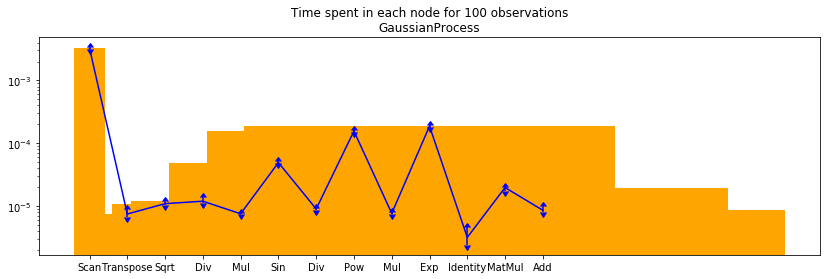

In [39]:
fig, ax = plt.subplots(1, 1, figsize=(14, 4))
ax.bar(df100.i, df100.time, align='center', color='orange')
ax.set_xticks(df100.i)
ax.set_yscale('log')
ax.set_xticklabels(df.op_type)
ax.errorbar(df100.i, df100.time, 
            numpy.abs(df100[["min_time", "max_time"]].T.values - df100.time.values.ravel()),
            uplims=True, lolims=True, color='blue')
ax.set_title("Time spent in each node for 100 observations\nGaussianProcess");

In [40]:
df100c = df100.cumsum()

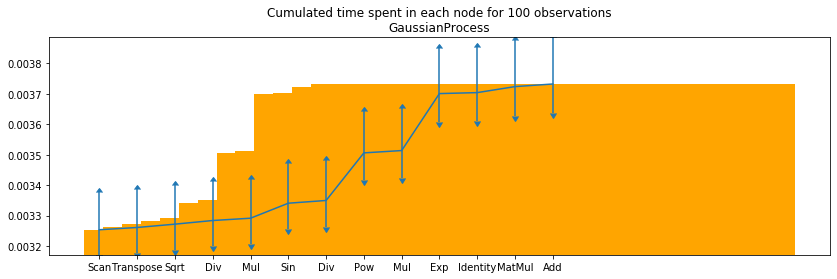

In [41]:
fig, ax = plt.subplots(1, 1, figsize=(14, 4))
ax.bar(df100.i, df100c.time, align='center', color='orange')
ax.set_xticks(df100.i)
#ax.set_yscale('log')
ax.set_ylim([df100c.min_time.min(), df100c.max_time.max()])
ax.set_xticklabels(df.op_type)
ax.errorbar(df100.i, df100c.time, 
            numpy.abs((df100c[["min_time", "max_time"]].T.values - df100c.time.values.ravel())),
            uplims=True, lolims=True)
ax.set_title("Cumulated time spent in each node for 100 observations\nGaussianProcess");

## onnxruntime2 / onnxruntime1

The runtime ``onnxruntime1`` uses *onnxruntime* for the whole ONNX graph. There is no way to get the computation time for each node except if we create a ONNX graph for each intermediate node.

In [42]:
oinfort1 = OnnxInference(onx, runtime='onnxruntime1')

In [43]:
split = oinfort1.build_intermediate()
split

OrderedDict([('scan0_1789206340776', OnnxInference(...)),
             ('scan1_1789206340776', OnnxInference(...)),
             ('kgpd_transposed0', OnnxInference(...)),
             ('kgpd_Y0', OnnxInference(...)),
             ('kgpd_C03', OnnxInference(...)),
             ('kgpd_C02', OnnxInference(...)),
             ('kgpd_output02', OnnxInference(...)),
             ('kgpd_C01', OnnxInference(...)),
             ('kgpd_Z0', OnnxInference(...)),
             ('kgpd_C0', OnnxInference(...)),
             ('kgpd_output01', OnnxInference(...)),
             ('kgpd_output0', OnnxInference(...)),
             ('gpr_Y0', OnnxInference(...)),
             ('GPmean', OnnxInference(...))])

In [44]:
dfs = []
for k, v in split.items():
    print("node", k)
    res = benchmark_fct(lambda x: v.run({'X': x}), X_test)
    df = pandas.DataFrame(res)
    df['name'] = k
    dfs.append(df.reset_index(drop=False))

node scan0_1789206340776
node scan1_1789206340776
node kgpd_transposed0
node kgpd_Y0
node kgpd_C03
node kgpd_C02
node kgpd_output02
node kgpd_C01
node kgpd_Z0
node kgpd_C0
node kgpd_output01
node kgpd_output0
node gpr_Y0
node GPmean


In [45]:
df = pandas.concat(dfs)
df.head()

,index,1,10,100,1000,10000,100000,name
0,average,0.000610,0.000665,0.000865,0.003190,0.023192,0.467448,scan0_1789206340776
1,deviation,0.000114,0.000127,0.000020,0.000568,0.000152,0.000000,scan0_1789206340776
2,min_exec,0.000545,0.000564,0.000841,0.002833,0.023009,0.467448,scan0_1789206340776
3,max_exec,0.001056,0.001041,0.000892,0.004320,0.023381,0.467448,scan0_1789206340776
4,repeat,20.000000,20.000000,5.000000,5.000000,3.000000,1.000000,scan0_1789206340776


In [46]:
df100c = df[df['index'] == "average"]
df100c_min = df[df['index'] == "min_exec"]
df100c_max = df[df['index'] == "max_exec"]
ave = df100c.iloc[:, 4]
ave_min = df100c_min.iloc[:, 4]
ave_max = df100c_max.iloc[:, 4]
ave.shape, ave_min.shape, ave_max.shape
index = numpy.arange(ave.shape[0])

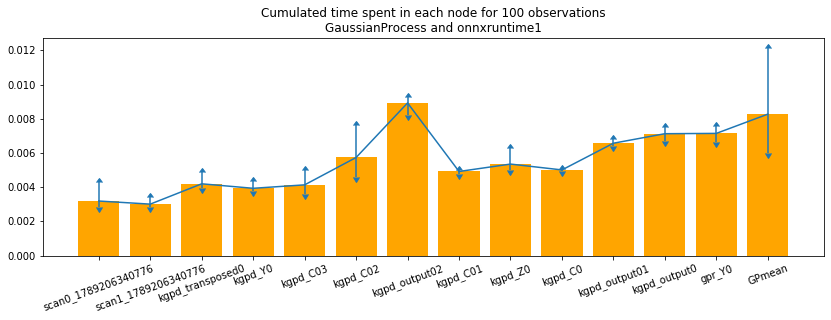

In [47]:
fig, ax = plt.subplots(1, 1, figsize=(14, 4))
ax.bar(index, ave, align='center', color='orange')
ax.set_xticks(index)
ax.set_xticklabels(df100c.name)
for tick in ax.get_xticklabels():
    tick.set_rotation(20)
ax.errorbar(index, ave, 
            numpy.abs((numpy.vstack([ave_min.values, ave_max.values]) - ave.values.ravel())),
            uplims=True, lolims=True)
ax.set_title("Cumulated time spent in each node for 100 observations\nGaussianProcess and onnxruntime1");

The visual graph helps matching the output names with the operator type. The curve is not monotononic because each experiment computes every output from the start. The number of repetitions should be increased. Documentation of function [benchmark_fct](http://www.xavierdupre.fr/app/mlprodict/helpsphinx/mlprodict/onnxrt/validate/validate.html?highlight=benchmark_fct#mlprodict.onnxrt.validate.validate.benchmark_fct) tells how to do it.